Training data shape: (4446, 48, 48, 1)
Testing data shape: (1112, 48, 48, 1)
Training labels shape: (4446, 8)
Testing labels shape: (1112, 8)


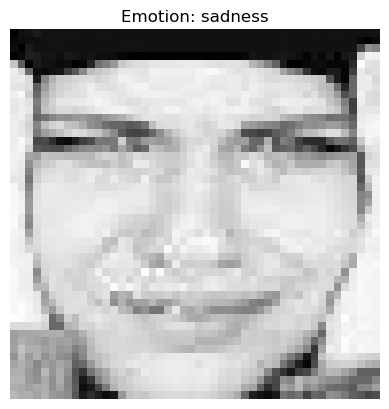

In [1]:
# install libraries
!pip install opencv-python-headless tensorflow numpy matplotlib

# libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# dataset path
data_path = "emotions_dataset"

# define emotions
emotion_labels = ['surprise', 'sadness', 'neutrality', 'happiness', 'fear', 'disgust', 'contempt', 'anger']
num_classes = len(emotion_labels)

# initialize data
data = []
labels = []

# preprocess images
for label in emotion_labels:
    emotion_folder = os.path.join(data_path, label)
    for image_name in os.listdir(emotion_folder):
        image_path = os.path.join(emotion_folder, image_name)
        try:
            # load image
            image = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
            image = img_to_array(image)
            image = image / 255.0  # Normalize the image

            # append image and label to lists
            data.append(image)
            labels.append(emotion_labels.index(label))
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# convert to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# convert to categorical
labels = to_categorical(labels, num_classes=num_classes)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# verify shape
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# display sample image w/ label
def plot_sample_image(data, labels, index):
    plt.imshow(data[index].reshape(48, 48), cmap='gray')
    plt.title(f"Emotion: {emotion_labels[np.argmax(labels[index])]}")
    plt.axis('off')
    plt.show()

plot_sample_image(X_train, y_train, 0)

# save data
np.savez('preprocessed_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

      Emotion  Training Count  Testing Count
0    surprise             599            176
1     sadness             588            158
2  neutrality             425             99
3   happiness            1131            275
4        fear             469            101
5     disgust             353             86
6    contempt             161             47
7       anger             720            170


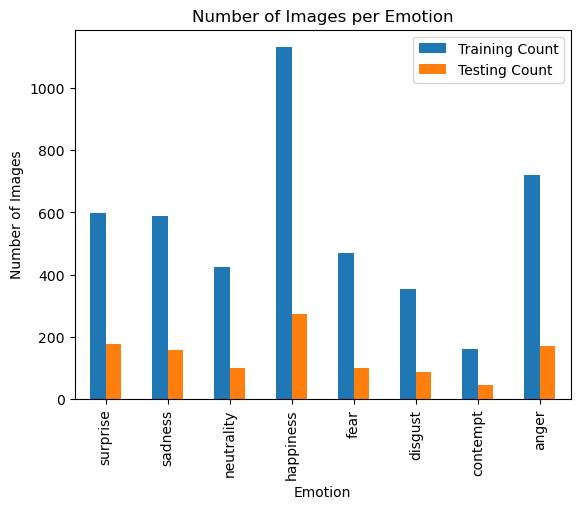

In [2]:
import pandas as pd

# count number of images for each emotion set
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

train_counts = pd.Series(train_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# print counts for each emotion
emotion_counts = pd.DataFrame({
    'Emotion': emotion_labels,
    'Training Count': train_counts,
    'Testing Count': test_counts
})

print(emotion_counts)

# display data
emotion_counts.plot(kind='bar', x='Emotion', title='Number of Images per Emotion')
plt.ylabel('Number of Images')
plt.show()

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# define cnn model
model = Sequential()

# first layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten maps into 1D vector
model.add(Flatten())

# connected dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_classes, activation='softmax'))

# print summary
model.summary()

C:\Users\brock\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,808 (4.38 MB)

 Trainable params: 1,147,336 (4.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [64]:
from tensorflow.keras.optimizers import Adam

# compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
# define epochs and batch size
epochs = 25
batch_size = 64

# train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.2013 - loss: 2.8960 - val_accuracy: 0.0890 - val_loss: 2.6539
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3059 - loss: 2.1492 - val_accuracy: 0.0773 - val_loss: 2.8474
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.3719 - loss: 1.9116 - val_accuracy: 0.0836 - val_loss: 3.4483
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3879 - loss: 1.7825 - val_accuracy: 0.0908 - val_loss: 3.2411
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.4356 - loss: 1.6407 - val_accuracy: 0.1502 - val_loss: 2.6871
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4572 - loss: 1.5355 - val_accuracy: 0.2950 - val_loss: 2.1369
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.4825 - loss: 1.4739 - val_accuracy: 0.3129 - val_loss: 2.0713
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.5125 - loss: 1.3870 - val_accuracy: 0.3264 -

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5157 - loss: 1.5059
Test accuracy: 0.5288


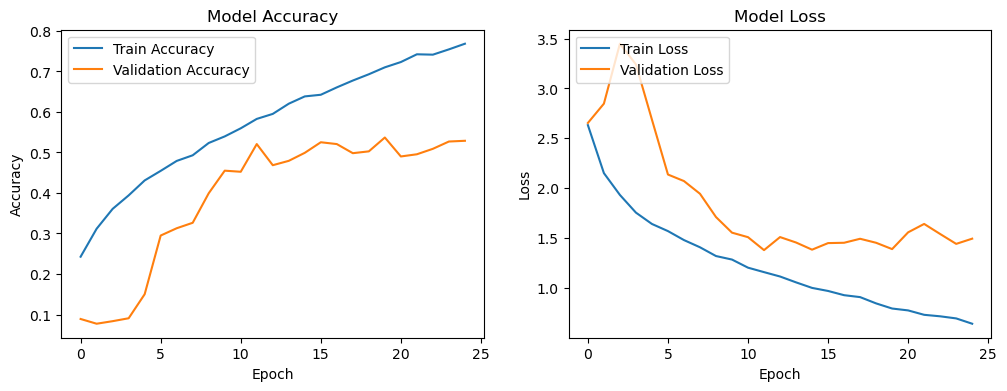

In [66]:
# evaluate test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

# plot accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()